# Exploratory Analysis

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Merged Data

In [2]:
data_path = 'D:\DATA\OurFoods'
df = pd.read_csv(os.path.join(data_path, 'merged_amz-off_2.csv.gz'),\
                 dtype={'customer_id': 'object', 'product_parent': 'object', \
                        'star_rating': pd.Int64Dtype(), 'helpful_votes': pd.Int64Dtype(), 
                        'total_votes': pd.Int64Dtype(), \
                        'code': 'object'},
                 compression='gzip')
# convert reivew_date to datetime object
df.review_date = pd.to_datetime(df.review_date)
df.shape

(147304, 129)

In [3]:
df.iloc[1010:1015, [3, 22, 25, 29]]
# values are the same, b.c. each row is a review

,product_title,energy_100g,saturated-fat_100g,-capric-acid_100g
1010,Monster Energy Drink,1004.0,0.0,NaN
1011,Monster Energy Drink,1004.0,0.0,NaN
1012,Monster Energy Drink,1004.0,0.0,NaN
1013,"Monster Energy Drink, M3, 5-Ounce Glass Contai...",1004.0,0.0,NaN
1014,Monster Energy Drink,1004.0,0.0,NaN


## Subset on main nutrients
+ Amazon Reivew attributes & Product Main Nutrients
+ including: ['energy_100g', 'fat_100g', 'fiber_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'sugars_100g']

In [4]:
main = ['energy_100g', 'fat_100g', 'fiber_100g', 'carbohydrates_100g', \
        'proteins_100g', 'salt_100g', 'sodium_100g', 'sugars_100g']
sub = df.loc[:, df.columns[:13].tolist()+main]

# extract only data with nutrients and remove outliners
# sub = sub[((sub.energy_100g.notna()) & (sub.energy_100g < 1000))]
sub = sub[((sub.energy_100g.notna()) & (sub.energy_100g < 3000))]

# get data after 2010
sub = sub[sub.review_date.dt.year >= 2010]
sub.shape

(137698, 21)

In [5]:
sub.energy_100g.mean()
# average energy per 100 g

1183.096259001277

In [6]:
sub[['review_date', 'star_rating']].groupby(sub.review_date.dt.year).count()
# not many data before 2005

,review_date,star_rating
review_date,,
2010,3130,3130
2011,5434,5434
2012,10420,10420
2013,28060,28060
2014,44152,44152
2015,46502,46502


### 1. Higher Energy Groceries during Colder Months?
+ group by each month, calculate mena energy value
+ group by each month, shown energy with scatterplot or boxplot

In [7]:
from calendar import month_name

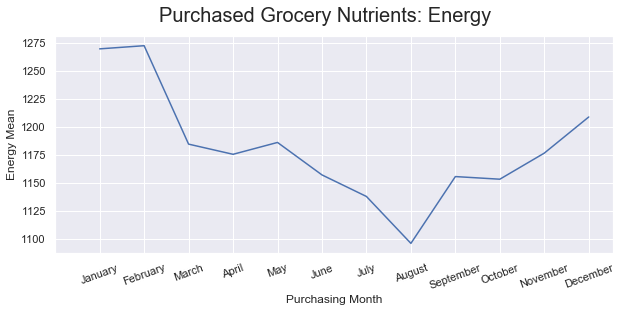

In [8]:
plt.figure(figsize=(10, 4))
tmp = sub[['review_date']+main].groupby(sub.review_date.dt.month)\
        .mean().reset_index().drop('fiber_100g', axis=1)
sns.lineplot(x='review_date', y='energy_100g', data=tmp)
plt.xlabel('Purchasing Month')
plt.xticks(np.arange(13), month_name[0:13], rotation=20)
plt.ylabel('Energy Mean')
plt.suptitle('Purchased Grocery Nutrients: Energy', fontsize=20)

# plt.savefig('./figures/nutrients-energy.png', bbox_inches='tight', dpi=300)
plt.show()
# why dropping at near August? need to investigate

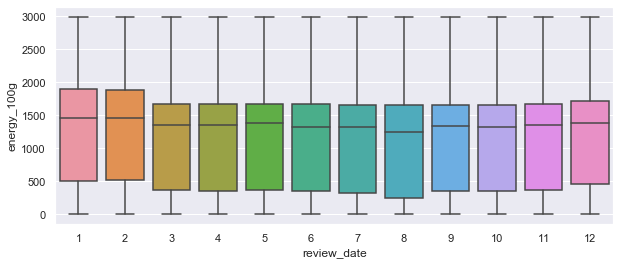

In [9]:
# shown with boxplot
plt.figure(figsize=(10, 4))
sns.boxplot(x=sub.review_date.dt.month, y=sub.energy_100g)
# plt.savefig('./figures/nutrients-energy.png', bbox_inches='tight', dpi=300)
plt.show()
# boxes are higher at 1, 2, and 12

### 2. Sweeter Foods have higher ratings?
+ segment 

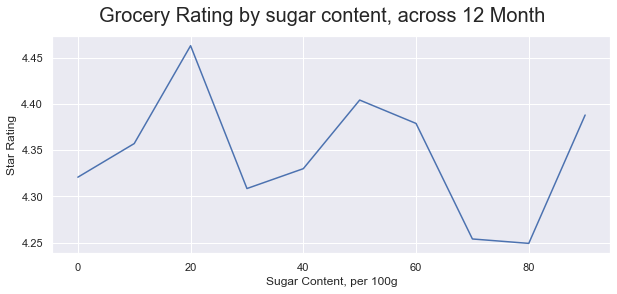

In [10]:
plt.figure(figsize=(10, 4))
# cut the sugars content into multiple bins
tmp = sub[['review_date', 'star_rating']+main]\
        .groupby(pd.cut(sub.sugars_100g,np.arange(0, 101, 10)))[['star_rating']].mean()
sns.lineplot(x=np.arange(0, 100, 10), y='star_rating', data=tmp)
plt.xlabel('Sugar Content, per 100g')
plt.ylabel('Star Rating')
plt.suptitle('Grocery Rating by sugar content, across 12 Month', fontsize=20)
# plt.savefig('./figures/sugar.png', bbox_inches='tight', dpi=300)
plt.show()

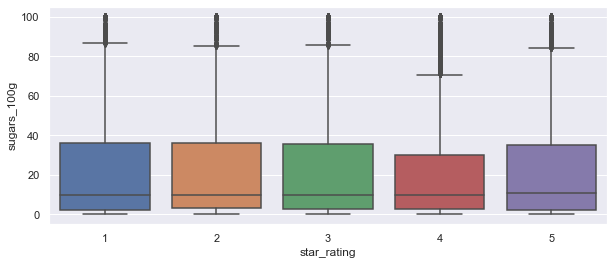

In [27]:
plt.figure(figsize=(10, 4))
sns.boxplot(x='star_rating', y='sugars_100g', data=sub)
# plt.savefig('./figures/sugar.png', bbox_inches='tight', dpi=300)
plt.show()

### 3. What are the Non-Verified reviews?

In [12]:
sub.verified_purchase.value_counts()

Y    115341
N     22357
Name: verified_purchase, dtype: int64

In [13]:
sub[sub.verified_purchase == 'N'].shape

(22357, 21)

In [23]:
sub[sub.verified_purchase == 'N'].tokens.value_counts().head(10)

('butter', 'chocolate', 'peanut', 'reeses', 'spreads')                    1979
('v',)                                                                    1097
('coco', 'coconut', 'vita', 'water')                                       448
('bell', 'pb', 'plantation')                                               323
('chip', 'chocolate', 'cookies', 'lactation', 'milkmakers', 'oatmeal')     267
('bai',)                                                                   239
('beef', 'jack', 'jerky', 'links')                                         217
('fiber', 'one')                                                           199
('butter', 'peanut', 'powdered')                                           177
('c',)                                                                     171
Name: tokens, dtype: int64

### 4. Healthy Conscious consumers?
+ with fiber and enery, average by each consumer

In [19]:
tmp = sub.groupby('customer_id', as_index=False)[['fiber_100g', 'energy_100g']].mean()
tmp = tmp[tmp.fiber_100g.notna()]
tmp.shape

(80207, 3)

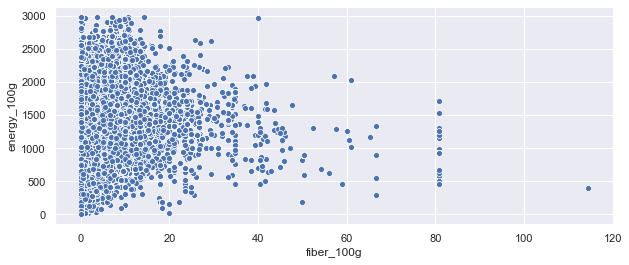

In [21]:
plt.figure(figsize=(10, 4))
sns.scatterplot(tmp.fiber_100g, tmp.energy_100g)
plt.show()
# a small group of consumers only purchase fiber_100g around 80